# 上市公司基本情况

- 使用tushare免费的基础信息数据集。(很遗憾,就在2023年5月底这几天,不免费了)
- 2024年7月底，使用akshare的工具从em和cninfo获取数据。
- 数据获取工具放在mytools中。在本文件夹中只拷贝了下载好的数据。
    - em_data.csv
    - cninfo_data.csv

## 数据集的基本情况

### em基本情况

In [4]:
import pandas as pd
import akshare as ak
from jinja2 import Environment, FileSystemLoader
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import numpy as np
from IPython.display import HTML

ModuleNotFoundError: No module named 'akshare'

In [3]:
# 解决matplotlib的中文问题
# bash中使用fc-list 找到family name
# plt.rcdefaults() # 样式调乱了，需要用它重置一下。
font_path = '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'
fm.fontManager.addfont(font_path)
# 设置全局字体为
matplotlib.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.style.use('ggplot')

In [169]:
def showProfile(df) :
    col_profile = pd.concat([df.dtypes, df.isna().sum()/len(df)*100, df.sample().T], axis=1 ).reset_index()
    col_profile.columns = ['列名', '类型', '缺失比%','样例']
    
    return (col_profile)

def fold_dataframe(df, n):
    # 确保 n 是正整数
    if n <= 0:
        raise ValueError("n 必须是正整数")
    # 添加一个新列，用于标记每一行的段号
    df = df.copy()
    m = len(df.columns)
    grey_list = [i for i in range(m, m*n+1, m+1)]
    df['id'] = [(i % n) for i in range(len(df))]
    # 使用groupby分成n组
    grouped = df.groupby('id')
    # 将每组取出来重设索引和列名
    segments = []
    for l, g in grouped:
        g = g.reset_index(drop=True)
        # 设置列格式时不支持重名的列，所以先把每组列名修改为不同
        g.columns =[f'{c}_{l}' for c in g.columns]
        segments.append(g)
    
    # 横向拼接起来
    folded_df = pd.concat(segments, axis=1)
    # folded_df = folded_df.astype('str')
    folded_df = folded_df.drop(columns=folded_df.columns[-1])
    folded_df = folded_df.replace(np.nan, '')
    # folded_df.iloc[:,grey_list] = folded_df.iloc[:,grey_list].astype('str') # 新建的列做为每组之间的分隔列
    # folded_df.iloc[:,grey_list] = ''
    def apply_color_by_position(df, cols_to_highlight):  
        '''  
        根据列位置为特定列设置红色背景色。  
        cols_to_highlight 是一个包含要设置样式的列位置的列表（从0开始计数）。  
        '''  
        # 创建一个空的DataFrame来存储样式  
        style_df = pd.DataFrame('', index=df.index, columns=df.columns)
        # 遍历要设置样式的列位置  
        for col_pos in cols_to_highlight:  
            # 注意：DataFrame.columns 返回一个Index对象，我们可以使用.iloc或.get_loc来获取位置对应的列名  
            col_name = df.columns[col_pos]  
            # 为该列的所有单元格设置背景色  
            style_df.loc[:, col_name] = 'background-color: grey; color: grey;'
        return style_df  
  
    # 调用函数并设置第2列和第3列（位置索引为1和2）的背景色为红色  
    folded_df = (folded_df.style
                 .format(precision=2)
                 .apply(apply_color_by_position, cols_to_highlight=grey_list, axis=None)
                 .relabel_index([i.split('_')[0] for i in folded_df.columns], axis=1)
                 .hide())  
    
    
    return folded_df

def plot_barh(df, title=None):
    height = len(df)*25/72+0.5
    ax = df.plot.barh(figsize=(10, height), width=0.8, legend=False, zorder=3)
    ax.bar_label(ax.containers[0], label_type='edge')
    ax.xaxis.tick_top()
    ax.xaxis.grid(True, color='#EEEEEE', zorder=0)
    ax.tick_params(left=False, bottom=False, top=False, right=False)
    title = title if title else df.columns[0]
    ax.set_title(title, fontsize=16, pad=20)
    
    plt.show(ax)

def plot_line(df, title=''):
    ax = df.plot.line(figsize=(10, 5), title=title)
    ax.tick_params(left=False, bottom=False)
    ax.yaxis.grid(True, color = '#EEEEEE')
    return plt.show(ax)

def df_cards(df, cols=None):
    """
    把df的每一行转化为html卡片形式。
    df: 整理好的DataFrame
    cols: 要展示的列名列表，需要在调用前进行修改。确定需要展示的样式：title, big, item, content等， 如果不提供，默认使用df的列名。
    """
    if not cols:
        cols = df.columns
    df.columns = [i for i in range(len(df.columns))]
    env = Environment(loader=FileSystemLoader('.'))
    template = env.get_template('cards.html')
    html_out = template.render(cols=cols, df=df)

    return HTML(html_out)

In [171]:
class BasicData:
    def __init__(self):
        self.em_df = pd.read_csv('em_data.csv',na_values=['', 'NA', 'N/A', '-'], dtype={'symbol':'str'})
        self.em_df = self.em_df.pivot(index='symbol', columns='item', values='value').reset_index()
        self.em_df['总市值'] = self.em_df['总市值'].astype('float')
        self.em_df.replace('-', np.nan, inplace=True)

        self.info_df = pd.read_csv('cninfo_data.csv', parse_dates=['上市日期', '成立日期'], dtype={'symbol':'str', '邮政编码':'str'})
        self.info_df['symbol'] = self.info_df['symbol'].astype(str)
        self.info_df['邮政编码'] = self.info_df['邮政编码'].str[:6]
        self.info_df['cname'] = self.info_df.fillna('')['A股简称'] + self.info_df.fillna('')['B股简称'] + self.info_df.fillna('')['H股简称']
        self.info_df['cname'] = self.info_df['cname'].str[:4] # 保留一个中文名称

    def get_zipcode(self):
        df = pd.read_csv('https://raw.githubusercontent.com/monkeyshare/zipcode_district/main/zipcode_district_data.csv', dtype={'district_phone':'str'})
        df.replace('–', '-', inplace=True)
        df.replace('86-', '0', inplace=True)
        return df[['province', 'district_phone']]
    
    def showProfile(self, df) :
        col_profile = pd.concat([df.dtypes, df.isna().sum()/len(df)*100, df.sample().T], axis=1 ).reset_index()
        col_profile.columns = ['列名', '类型', '缺失比%','样例']
        return (col_profile)
    
    def dlisted(self):
        dl = len(self.em_df[self.em_df['总股本'].isna()])
        l =  len(self.em_df) - dl
        rows = [
            ['上市数量', l],
            ['退市数量', dl]
        ]
        res = pd.DataFrame(rows, columns=['title', 'huge'])
        return res
    
    def new_listed(self):
        byy=(self.em_df['上市时间'].dropna().groupby(self.em_df['上市时间'].str[:4]).count().to_frame(name='年度新增上市数量'))
        bym=(self.em_df['上市时间'].dropna().groupby(self.em_df['上市时间'].str[4:6]).count().to_frame(name='月份新增上市数量'))
        byd=(self.em_df['上市时间'].dropna().groupby(self.em_df['上市时间'].str[6:]).count().to_frame(name='按日新增上市数量'))
        topm = (self.em_df['上市时间'].dropna().groupby(self.em_df['上市时间'].str[:6]).count().sort_values(ascending=1)).to_frame('上市数量最多的月份前十').tail(10)
        topd = (self.em_df['上市时间'].dropna().groupby(self.em_df['上市时间'].str[:8]).count().sort_values(ascending=1)).to_frame('上市数量最多的日期前十').tail(10)
        return (byy, bym, topm, byd,  topd)
    
    def cninfo(self):
        by_market = self.info_df.groupby('所属市场')['symbol'].count().sort_values().to_frame('分市场上市公司数量')
        by_year = self.info_df.copy()
        by_year['lyear'] = by_year['上市日期'].dt.year
        bymy = by_year.pivot_table(index='lyear', columns='所属市场', values='symbol', aggfunc='count')
        top_indu = by_year['所属行业'].groupby(by_year['所属行业']).count().sort_values(ascending=1).tail(40).to_frame(name='拥挤行业')
        tail_indu = by_year['所属行业'].groupby(by_year['所属行业']).count().sort_values(ascending=0).tail(40).to_frame(name='冷清行业')
        return (by_market, [bymy, '各板块上市公司数量变化'], top_indu, tail_indu)
    
    def find_cname(self, text, n=40, fold=3):
        df = self.info_df[self.info_df.apply(lambda col: col.astype('str').str.contains(text)).any(axis=1)][['symbol', 'cname']]
        if len(df) < 1:
            return '未找到'
        df = df.merge(self.em_df[['symbol', '总市值']])
        df['总市值'] = pd.to_numeric(df['总市值'], errors='coerce')
        df['总市值'] = df['总市值'].apply(lambda x: round(x/100000000, 2))
        df = df.sort_values(by ='总市值', ascending=0)

        n = n if n < len(df) else len(df)
        res = df[['cname', '总市值']].set_index('cname')
        res = res.sort_values(by ='总市值', ascending=1).tail(n)
        res.columns = [f'{text}相关上市公司市值排名前{n}/{len(df)}']
        # bar = plot_barh(res, title)
        def styled_df(df=df, fold=fold):
            folded = fold_dataframe(df, fold)
            display(HTML(f"<h2>{len(df)}家{text}相关上市公司</h2>"))
            display(folded)
        styled = styled_df()
        
        return [res, styled]
    
    def by_province(self):
        df = self.info_df[['symbol','联系电话']].copy()
        zipcode = self.get_zipcode().drop_duplicates('district_phone')
        df['区号'] = df['联系电话'].str.split('-').str[0]
        zipcode = zipcode.drop_duplicates('district_phone')
        df = df.merge(zipcode, left_on='区号', right_on='district_phone', how='left')
        res = df.groupby('province')['symbol'].count().sort_values(ascending=1).to_frame('按省分上市公司数量')
        return plot_barh(res)

bd = BasicData()

In [207]:
bd.showProfile(bd.em_df)

,列名,类型,缺失比%,样例
0,symbol,object,0.000000,300820
1,上市时间,object,0.088936,20200213
2,总市值,float64,4.500178,8381123150.009999
3,总股本,object,4.446816,220730133.0
4,流通市值,object,4.517965,4181290231.27
5,流通股,object,4.517965,110120891.0
6,股票代码,object,0.000000,300820
7,股票简称,object,0.000000,英杰电气
8,行业,object,4.589114,电源设备


这个数据是更新至下载当天的情况：

- 股票代码中包括了已经退市的股票，特征是总股本为‘-’。
- 包括待上市的股票，特征旧总市值为’-‘。
- 总市值是下载当天的数据，可以用来做一些基本分析。

### cninfo基本情况

In [208]:
bd.showProfile(bd.info_df)

,列名,类型,缺失比%,样例
0,公司名称,object,0.000000,深圳市深科达智能装备股份有限公司
1,英文名称,object,0.000000,"Shenzhen S-king Intelligent Equipment Co., Ltd."
2,曾用简称,object,74.319284,NaN
3,A股代码,float64,0.018650,688328.0
4,A股简称,object,0.018650,深科达
5,B股代码,float64,98.619918,NaN
6,B股简称,object,98.619918,NaN
7,H股代码,float64,97.239836,NaN
8,H股简称,object,97.239836,NaN
9,入选指数,object,14.994405,国证Ａ指


cninfo可以分析的点
- 分市场的上市公司数量。
- 成立时期到上市日期的时间跨度。
- 分行业上市公司数量。
- 主营业务和经营范围包含某个关键词的公司数量。

## 上市和退市

- 至数据更新时,A股三市现存上市公司5372家。
- 退市250家，但由于没有退市日期，无法分年度分析。

In [34]:
df_cards(bd.dlisted())

## 每年新增上市公司
- 上市公司，分板块，分市场，分行业情况.


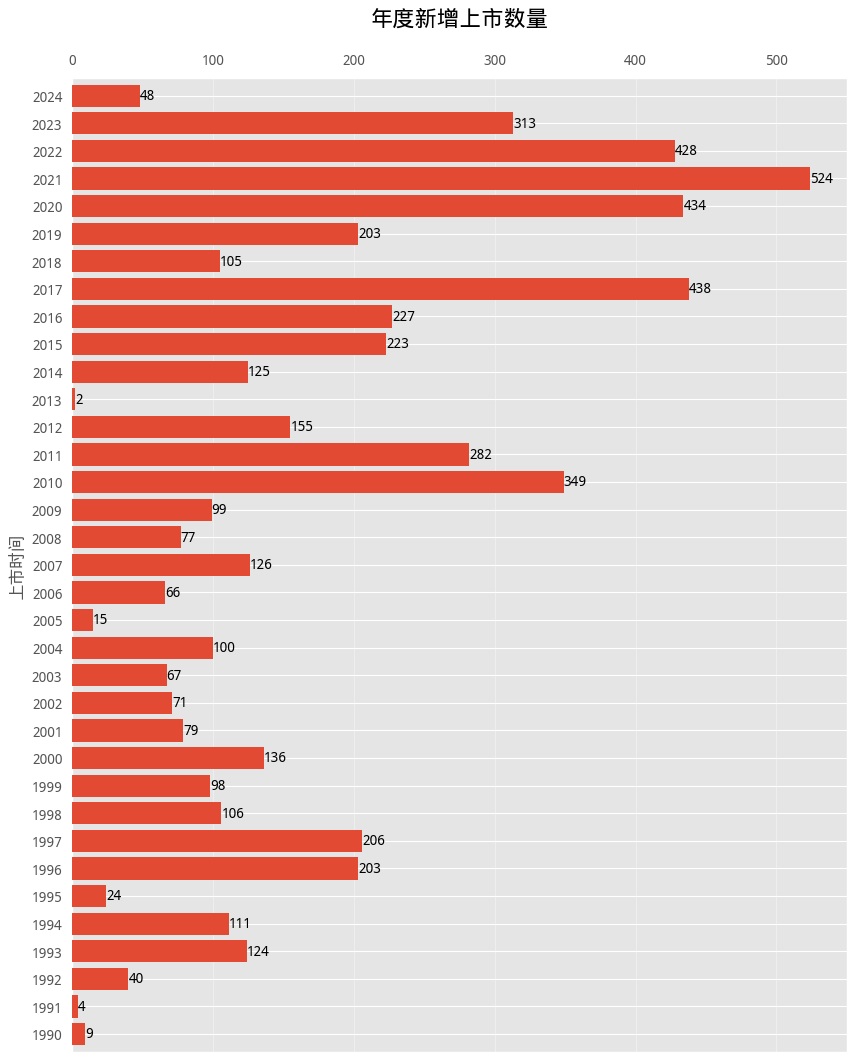

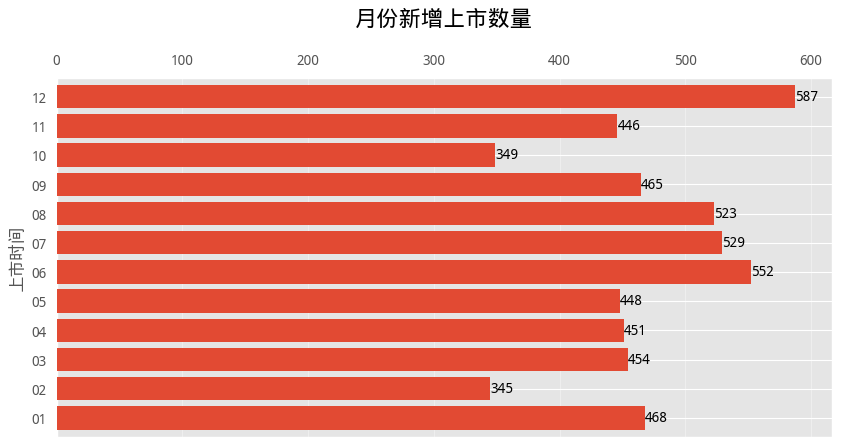

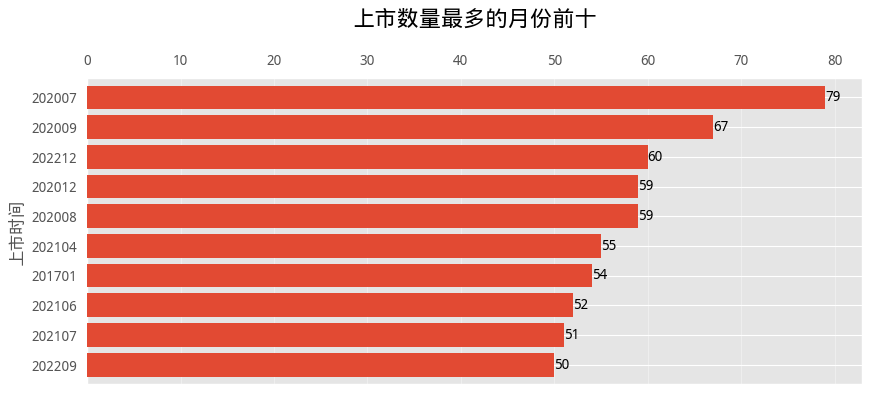

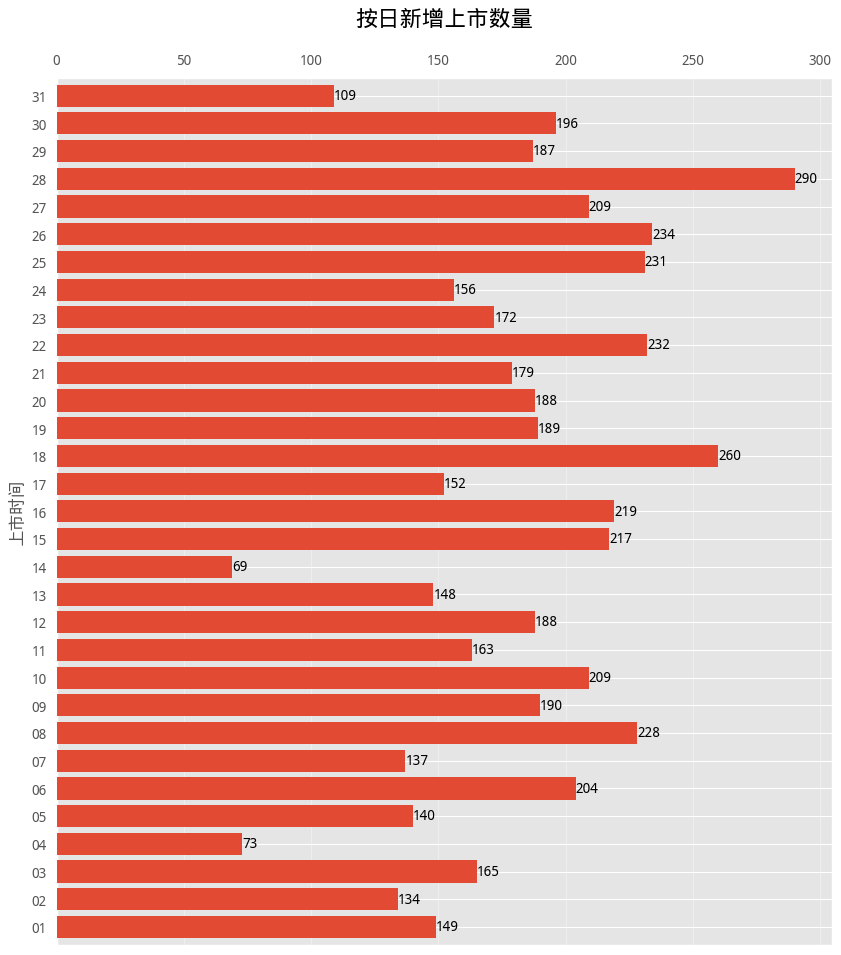

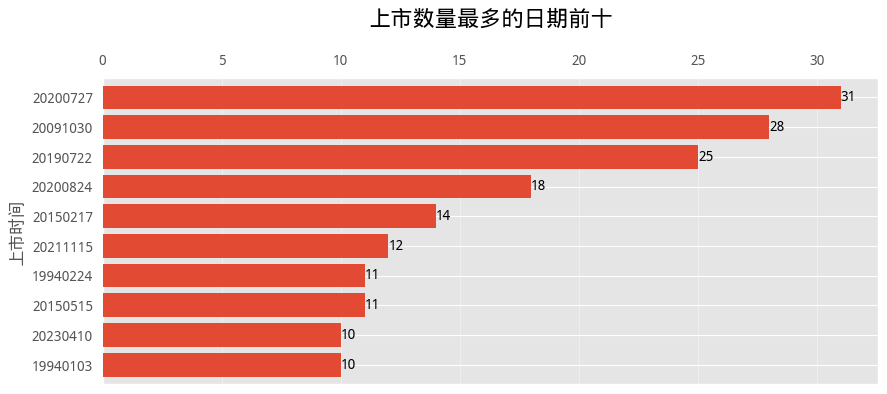

In [ ]:
for g in bd.new_listed():
    plot_barh(g)

- 疫情三年各疫情前的2019年，上市公司数量增长大跃进。
- 2024年，时间过半之后，仍然增长只有几十家，预计会是个小年。
- 喜欢在12月、1月和6月上市。
- 28号、18号和8号是最受欢迎的上市日期。
- 从具体单日新增长上市公司数量来看，从2009年开始，每十年会有疯狂的时候。

## 交易所和板块
- 三个交易所,四个板块
- 从交易所上市数量来看，深交所规模最大，北交所成立较晚规模最小
- 主板规模最大

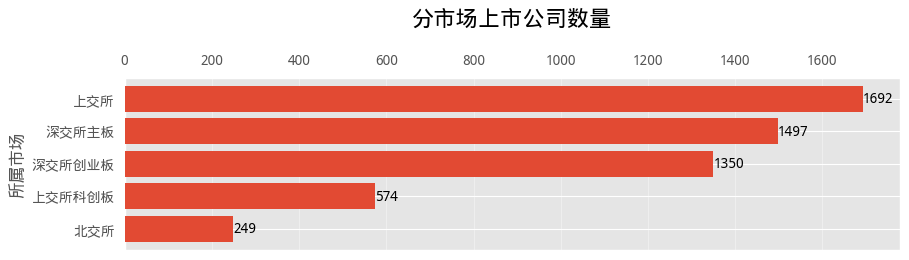

In [ ]:
plot_barh(bd.cninfo()[0])

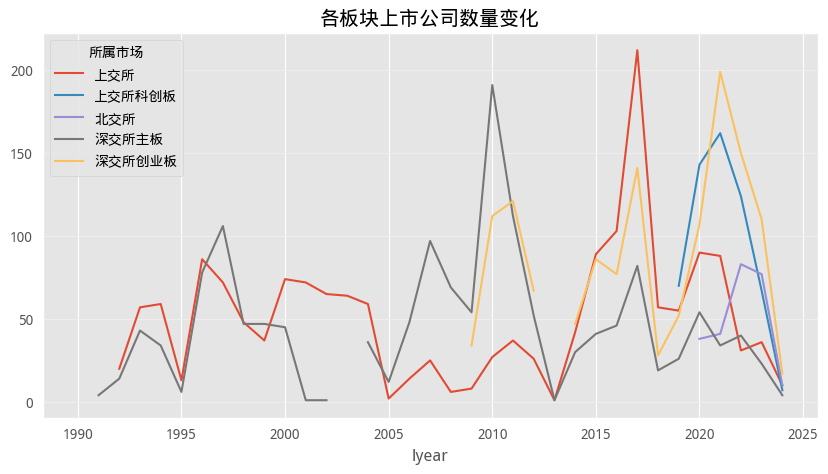

In [ ]:
plot_line(*bd.cninfo()[1])

- 北交所没有区分板块
- 上交所交易主板和科创板
- 深交所交易主板和创业板

## 分行业

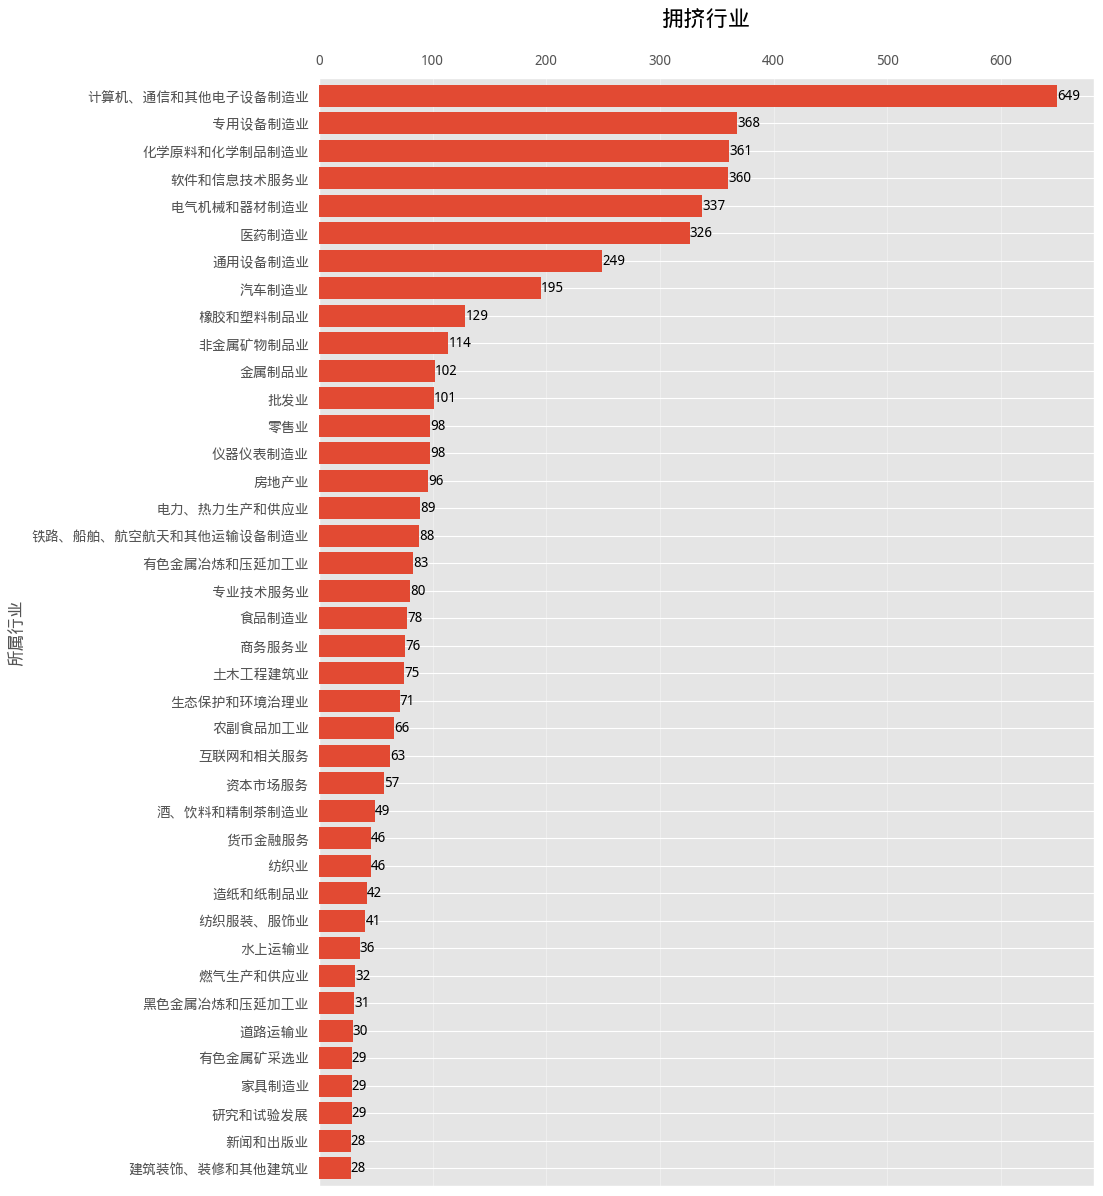

In [ ]:
plot_barh(bd.cninfo()[2])

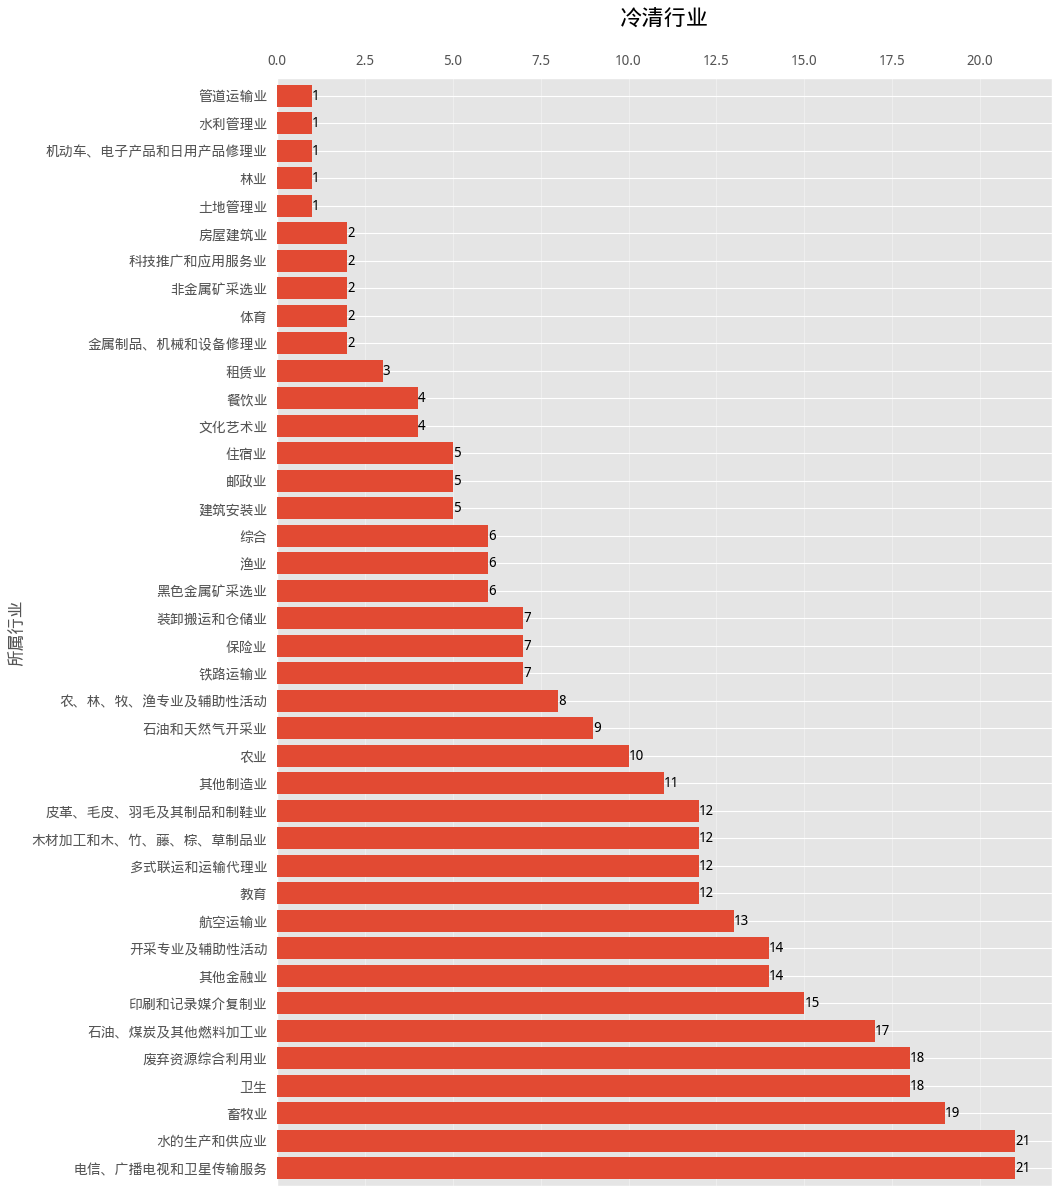

In [ ]:
plot_barh(bd.cninfo()[3])

## 分省市情况
- 广东省一枝独秀，主要是包括了深圳。
- 江、浙旗鼓相当。
- 上、北相差不大。
- 山东独占一档。
- 四川在内陆省份中排了第一。

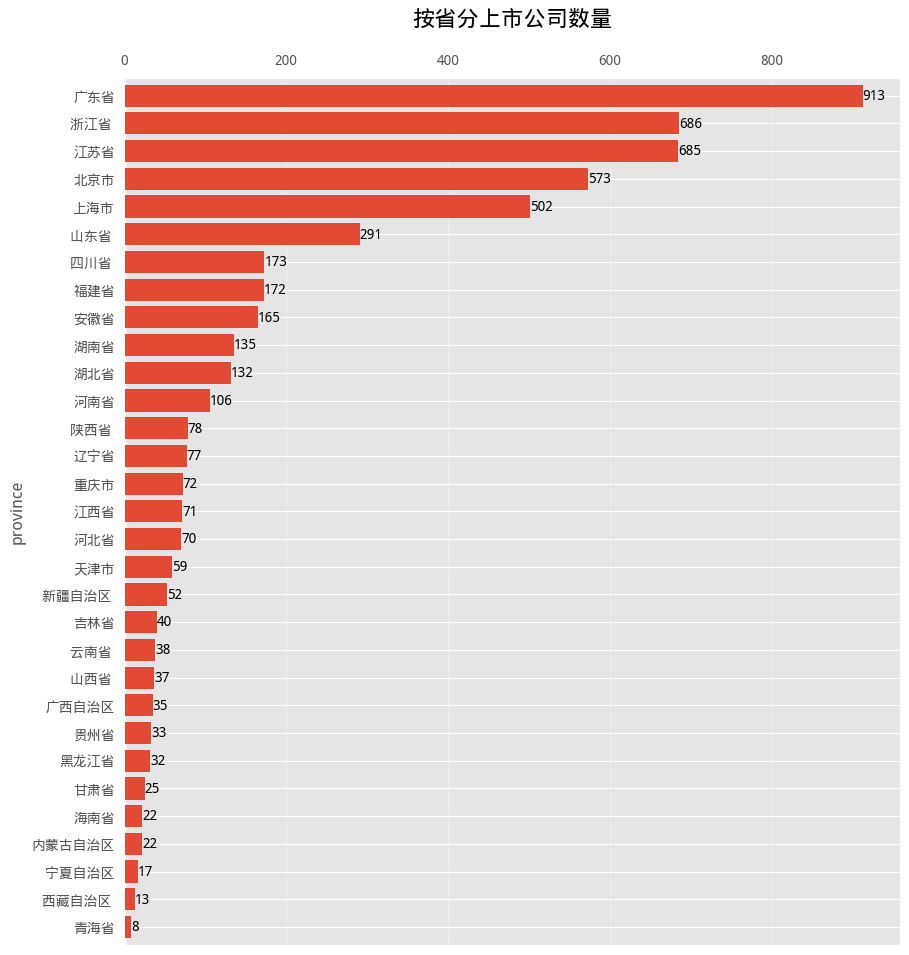

In [ ]:
bd.by_province()

## 按关键词搜索
通过搜索关键词找出在名字、行业、经营范围、主营业务中包含关键词的公司。
- 输入：关键词，显示条数。
- 结果按总市值排序，数值是获得数据集当天的数。
- 搜索数据比较多，所以默认显示前20条。
- 关键字可能是正则式。
- 搜索结果中总市值为空的是未上市的公司。

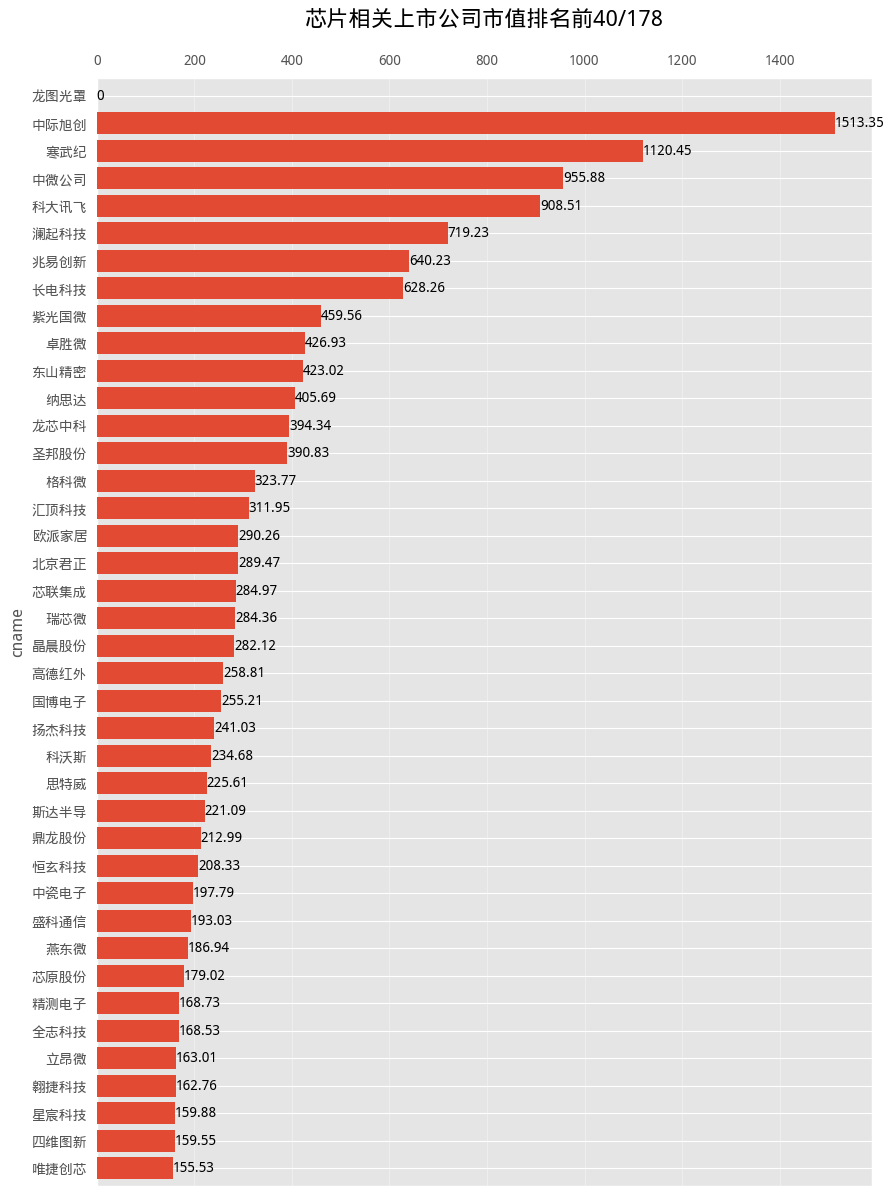

In [ ]:
plot_barh(bd.find_cname('芯片')[0])

In [175]:
bd.find_cname('银行', fold=3)[1]

symbol,cname,总市值,id,symbol,cname,总市值,id,symbol,cname,总市值
601398,工商银行,21063.61,0,601939,建设银行,18875.83,1,601288,农业银行,16484.20
601988,中国银行,13747.91,0,600036,招商银行,8637.80,1,601318,中国平安,7835.86
601328,交通银行,5540.00,0,601658,邮储银行,4938.22,1,601166,兴业银行,3558.64
601998,中信银行,3442.60,0,600030,中信证券,2873.70,1,601601,中国太保,2857.24
600000,浦发银行,2562.45,0,601319,中国人保,2401.36,1,000001,平安银行,2012.39
601818,光大银行,1991.18,0,600016,民生银行,1659.35,1,601066,中信建投,1524.19
002142,宁波银行,1473.92,0,600919,江苏银行,1440.58,1,601995,中金公司,1391.22
600999,招商证券,1278.39,0,601211,国泰君安,1250.97,1,601600,中国铝业,1245.70
601169,北京银行,1190.35,0,601688,华泰证券,1162.98,1,601229,上海银行,1064.08
601009,南京银行,1049.90,0,600015,华夏银行,1036.06,1,601336,新华保险,977.98


In [176]:
import nbformat as nbf
from pathlib import Path
def remove_input():
    fn = Path('01_listed.ipynb')
    nb = nbf.read(fn, nbf.NO_CONVERT)
    for cell in nb.cells:
        cell_tags = cell.get('metadata', {}).get('tags', [])
        if not 'remove_input' in cell_tags:
            cell_tags.append('remove_input')
            cell['metadata']['tags'] = cell_tags
    nbf.write(nb, fn)
remove_input()